# Evaluating BGP catchment on Tangled testbed
* Joao Ceron - ceron@botlog.org

In [2]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
plt.style.use('default')
from IPython.core.display import display, HTML
%matplotlib inline
from matplotlib import ticker
import os.path
import re
import numpy as pynum_float

In [20]:
# convert names to airport code
di = {"uk-lnd-anycast02": "LHR", 
      'us-mia-anycast01':"MIA", 
      "au-syd-anycast01":"SYD",
      'fr-par-anycast01': "CDG",
      'jp-hnd-anycast01': "HND",
      'br-poa-anycast01': "POA",
      'us-was-anycast01': "IAD",
      'nl-ens-anycast02': "ENS",
      'vultr-nodes' : 'vultr-nodes',
      'ampath-nodes' : 'ampath-nodes',
      'unknown': 'unknown',
      'baseline': 'baseline',
      'all': 'baseline',
     }
di_short = {
      "uk-lnd": "LHR", 
      'us-mia':"MIA", 
      "au-syd":"SYD",
      'fr-par': "CDG",
      'jp-hnd': "HND",
      'br-poa': "POA",
      'us-was': "IAD",
      'vultr-nodes' : 'vultr-nodes',
      'ampath-nodes' : 'ampath-nodes',
      'unknown': 'unknown',
      'baseline': 'baseline',
      'all': 'baseline'
}

In [21]:
# plt.style.available[:5]

---
---
<h1 align="center">Functions</h1>

---
---

In [22]:
def init_fig(width=12,height=5):
    
    fig = plt.figure(figsize=(width, height))
    ax = plt.subplot(111)   
    ax.set_facecolor("#ffffff")
    ax.spines['bottom'].set_color('0.5')
    ax.spines['top'].set_color('0.5')
    ax.spines['right'].set_color('0.5')
    ax.spines['left'].set_color('0.5')
    fig.tight_layout();
    plt.style.use('default')
    
    return (fig,ax)

In [23]:
def get_and_plot_reference_value(df,site):

    
    df_site = df[df['site']==site].sort_values(by="bgp")
    reference_value = df_site[df_site.bgp=="baseline"].iloc[0,2]

    label = "[{}%] BASELINE".format(int(reference_value))
    # reference value annotation
    ax.annotate(label,xy=(25, reference_value), ha='right',color='black',va='bottom')
    # reference value line
    ax.axhline(y=reference_value, xmin=-1, xmax=1.0, color='grey', linestyle='dotted')

    return (reference_value)

In [24]:
!pwd

/Users/ceron/work/SAND/paper_bgp_catchment_manipulation/data_analysis/server_load


---
---
<h1 align="center">Read files and build dataframe</h1>

---
---

In [129]:
# get files, parse them and use their names
df_all = pd.DataFrame()
dir = "/Users/ceron/work/SAND/paper_bgp_catchment_manipulation/data_analysis/server_load/load-com/*load*.txt"
count = 0
for file in (glob.glob(dir)):
    count +=1
    filename = os.path.basename(file)
    print ("working on file: {}".format(filename))
    
    
    # read header of stats load file
    fd = open(file, 'r') 
    for line in fd.readlines():
        if ("date" in line):
            id = line.split(",")[1].rstrip('\n')
        elif ("bgp_policy" in line):
            bgp = line.split(",")[1].rstrip('\n')
        elif ("active_nodes" in line):
            active_nodes = line.split(",")[1].rstrip('\n')
    ###
    ### BUILD Dataframe using load files 
    ###
    #1 - process the baseline stats file - regular prefixes announcemnt
    if (bool(re.search('baseline', filename))):   
        df = pd.read_csv(file,names=['site', 'count','percent'],skiprows=4)       
        df['bgp_policy'] = "baseline"
        df['time'] = id
        df['bgp_policy_location'] = "all"
        df['num_prepend'] = 0
        df['community'] = "None"
        df['percent'] = (df['count']/df['count'].sum()).mul(100).round(3)
        df_all = pd.concat([df, df_all],sort=False) 
            
    # 2 - process communities load files
    elif re.search(r'load-new-community', filename, re.M):
        df = pd.read_csv(file,names=['site', 'count','percent'],skiprows=4)  
        site = re.search('.*(\w{2}-\w+)-anycast\d{2}', bgp).group(1)
        community = (re.search('community-([0-9:,]+)-\w\w-.*cast\d\d',bgp).group(1))
        df['bgp_policy'] = "community"
        df['time'] = id
        df['bgp_policy_location'] = site
        df['num_prepend'] = 0
        df['community'] = community
        df['percent'] = (df['count']/df['count'].sum()).mul(100).round(3)
        df_all = pd.concat([df, df_all],sort=False) 
    else:
        print ("file ignored {}".format(filename))

print ("Files processed: {}".format(count))
df=df_all
df['site'] = df['site'].map(di)
df['bgp_policy_location'] = df['bgp_policy_location'].map(di_short)
df.head()

working on file: load-new-community-20080:702-us-mia-anycast01-1584392852.txt
working on file: load-new-community-20080:802-us-mia-anycast01-1584392852.txt
working on file: load-new-community-20080:804-us-mia-anycast01-1584392852.txt
working on file: load-new-community-20080:801-us-mia-anycast01-1584392852.txt
working on file: load-new-community-20080:701-us-mia-anycast01-1584392852.txt
working on file: load-new-community-20080:700-us-mia-anycast01-1584392852.txt
working on file: load-new-baseline-#ipv4,br-poa,us-los,us-was,fr-1584392852.txt
working on file: load-new-community-20080:110-us-mia-anycast01-1584392852.txt
working on file: load-new-community-20080:803-us-mia-anycast01-1584392852.txt
working on file: load-new-community-20080:150-us-mia-anycast01-1584392852.txt
Files processed: 10


,site,count,percent,bgp_policy,time,bgp_policy_location,num_prepend,community
0,POA,969347,15.824,community,,MIA,0,20080:150
1,LHR,862906,14.087,community,,MIA,0,20080:150
2,SYD,858327,14.012,community,,MIA,0,20080:150
3,ENS,548831,8.959,community,,MIA,0,20080:150
4,CDG,334925,5.467,community,,MIA,0,20080:150


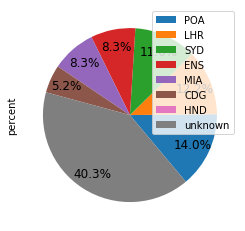

In [130]:
fig = plt.figure(figsize=(5, 4))
ax = plt.subplot2grid((1,1), (0,0))
result = df[df['bgp_policy'].str.contains("baseline")].copy()
result.set_index('site',inplace=True)
result.plot(ax=ax, 
            y='percent',
            autopct=make_autopct(result['count']),
            startangle=-50, 
            pctdistance=0.8, 
            kind="pie",
            fontsize=12,
            labels=None)

In [134]:
df['bgp'] = df['community']
data = df.groupby(['site','bgp'])['count'].sum().unstack().T.fillna(0).rename_axis(None, axis=1)
data = data.reset_index()
data.loc[data['bgp'] == "None","bgp"] = "baseline"
data.loc[data['bgp'] == "20080:110","bgp"] = "locpref 100"
data.loc[data['bgp'] == "20080:150","bgp"] = "locpref 150"
data.loc[data['bgp'] == "20080:700","bgp"] = "no-peering"
data.loc[data['bgp'] == "20080:701","bgp"] = "no-customer"
data.loc[data['bgp'] == "20080:702","bgp"] = "no-upstream"
data.loc[data['bgp'] == "20080:801","bgp"] = "one-prepend"
data.loc[data['bgp'] == "20080:802","bgp"] = "two-prepend"
data.loc[data['bgp'] == "20080:803","bgp"] = "three-prepend"
data.loc[data['bgp'] == "20080:804","bgp"] = "four-prepend"
data.set_index("bgp",inplace=True)
data = data.iloc[::-1]
data

,CDG,ENS,HND,LHR,MIA,POA,SYD,unknown
bgp,,,,,,,,
baseline,320153,508446,1,747272,505605,860554,712899,2470826
four-prepend,323485,508045,1,712690,528230,862021,689573,2501711
three-prepend,337323,552198,1,854814,13251,971145,847857,2549167
two-prepend,321258,503372,1,710692,526907,854217,696242,2513067
one-prepend,320623,503777,1,711769,527002,856338,700964,2505282
no-upstream,335434,550884,1,867551,2,971255,876320,2524309
no-customer,321393,508609,1,715922,518570,862864,707652,2490745
no-peering,320849,508571,1,715876,525571,863741,710701,2480446
locpref 150,334925,548831,1,862906,2,969347,858327,2551417


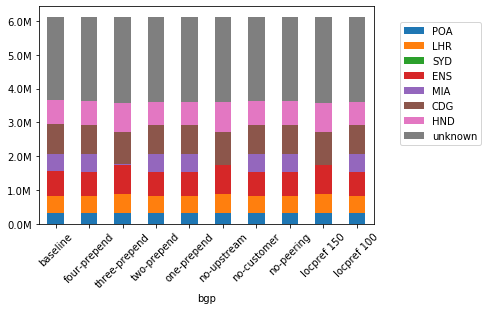

In [188]:
fig = plt.figure(figsize=(6, 4))
ax = plt.subplot2grid((1,1), (0,0))
data.plot(ax=ax,    kind='bar', 
    stacked=True,
    );
ax.set_yticklabels(['{:,}M'.format((x/1000000)) for x in ax.get_yticks().tolist()]);
ax.legend(labels, loc='upper center', bbox_to_anchor=(1.2,0.95))
xlabels = ax.get_xticklabels()

ax.set_xticklabels(xlabels, rotation=45);

In [145]:
data["MIA"] 

bgp
baseline         505605
four-prepend     528230
three-prepend     13251
two-prepend      526907
one-prepend      527002
no-upstream           2
no-customer      518570
no-peering       525571
locpref 150           2
locpref 100      525063
Name: MIA, dtype: int64

,MIA
bgp,
baseline,505605
no-upstream,2
locpref 150,2
no-peering,525571
locpref 100,525063


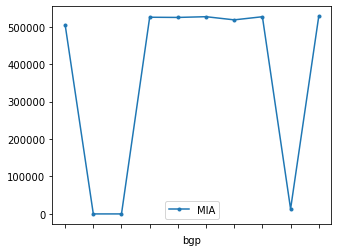

In [185]:
fig = plt.figure(figsize=(5, 4))
ax = plt.subplot2grid((1,1), (0,0))

da = data["MIA"].reset_index() 
da.bgp = pd.Categorical(da.bgp,categories=
['baseline','no-upstream','locpref 150','no-peering','locpref 100','one-prepend','no-customer','two-prepend','three-prepend','four-prepend'])
da = da.sort_values(by="bgp")
da.set_index('bgp',inplace=True)
da.plot(ax=ax, marker=".")
ax.xaxis.set_major_locator(plt.MaxNLocator(10))

da.head()

In [126]:
df['bgp'] = df['community']
data = df.groupby(['site','bgp'])['percent'].sum().unstack().T.fillna(0).rename_axis(None, axis=1)
data = data.reset_index()
data.loc[data['bgp'] == "None","bgp"] = "baseline"
data.loc[data['bgp'] == "20080:110","bgp"] = "locpref 100"
data.loc[data['bgp'] == "20080:150","bgp"] = "locpref 150"
data.loc[data['bgp'] == "20080:700","bgp"] = "no-peering"
data.loc[data['bgp'] == "20080:701","bgp"] = "no-customer"
data.loc[data['bgp'] == "20080:702","bgp"] = "no-upstream"
data.loc[data['bgp'] == "20080:801","bgp"] = "one-prepend"
data.loc[data['bgp'] == "20080:802","bgp"] = "two-prepend"
data.loc[data['bgp'] == "20080:803","bgp"] = "three-prepend"
data.loc[data['bgp'] == "20080:804","bgp"] = "four-prepend"
data.set_index("bgp",inplace=True)
data = data.iloc[::-1]
data

,CDG,ENS,HND,LHR,MIA,POA,SYD,unknown
bgp,,,,,,,,
baseline,5.226,8.300,0.0,12.199,8.254,14.048,11.638,40.335
four-prepend,5.281,8.294,0.0,11.634,8.623,14.072,11.257,40.839
three-prepend,5.507,9.014,0.0,13.954,0.216,15.853,13.841,41.614
two-prepend,5.244,8.217,0.0,11.602,8.602,13.945,11.366,41.025
one-prepend,5.234,8.224,0.0,11.619,8.603,13.979,11.443,40.898
no-upstream,5.476,8.993,0.0,14.162,0.000,15.855,14.305,41.208
no-customer,5.247,8.303,0.0,11.687,8.465,14.086,11.552,40.660
no-peering,5.238,8.302,0.0,11.686,8.580,14.100,11.602,40.492
locpref 150,5.467,8.959,0.0,14.087,0.000,15.824,14.012,41.651


---
---
<h1 align="center">Baseline Catchment</h1>

---
---

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


,count,percent,bgp_policy,time,bgp_policy_location,num_prepend,community
site,,,,,,,
POA,860554,14.048,baseline,,baseline,0,None
LHR,747272,12.199,baseline,,baseline,0,None
SYD,712899,11.638,baseline,,baseline,0,None
ENS,508446,8.300,baseline,,baseline,0,None
MIA,505605,8.254,baseline,,baseline,0,None
CDG,320153,5.226,baseline,,baseline,0,None
HND,1,0.000,baseline,,baseline,0,None
unknown,2470826,40.335,baseline,,baseline,0,None


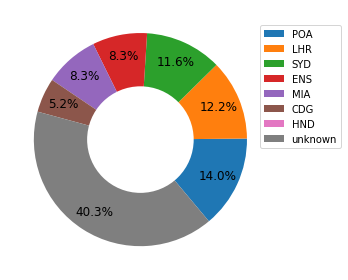

In [29]:

fig = plt.figure(figsize=(5, 4))
ax = plt.subplot2grid((1,1), (0,0))

def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        if (val==0):
            return 
        return '{p:.1f}%'.format(p=pct,v=val)
    return my_autopct

result = df[df['bgp_policy'].str.contains("baseline")].copy()
result.set_index('site',inplace=True)
result.plot(ax=ax, 
            y='percent',
            autopct=make_autopct(result['count']),
            startangle=-50, 
            pctdistance=0.8, 
            kind="pie",
            fontsize=12,
            labels=None)

labels=result.index
ax.legend(labels, loc='upper center', bbox_to_anchor=(1.1,0.95))

centre_circle = plt.Circle((0,0),0.50,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle);
ax.set_ylabel('')
fig.tight_layout()
fig.show()
result

---
---
<h1 align="center">Catchment investigation using prepends</h1>

---
---

# Communities

In [34]:
df.tail()

,site,count,percent,bgp_policy,time,bgp_policy_location,num_prepend,community
3,ENS,508446,8.300,baseline,,baseline,0,None
4,MIA,505605,8.254,baseline,,baseline,0,None
5,CDG,320153,5.226,baseline,,baseline,0,None
6,HND,1,0.000,baseline,,baseline,0,None
7,unknown,2470826,40.335,baseline,,baseline,0,None


# OVERALL

## A - positive prepend

In [30]:
regex_prepend_site = "prepend|baseline|all"
data = df[df['bgp_policy'].str.contains(regex_prepend_site)].copy()
data


,site,count,percent,bgp_policy,time,bgp_policy_location,num_prepend,community
0,POA,860554,14.048,baseline,,baseline,0,None
1,LHR,747272,12.199,baseline,,baseline,0,None
2,SYD,712899,11.638,baseline,,baseline,0,None
3,ENS,508446,8.300,baseline,,baseline,0,None
4,MIA,505605,8.254,baseline,,baseline,0,None
5,CDG,320153,5.226,baseline,,baseline,0,None
6,HND,1,0.000,baseline,,baseline,0,None
7,unknown,2470826,40.335,baseline,,baseline,0,None


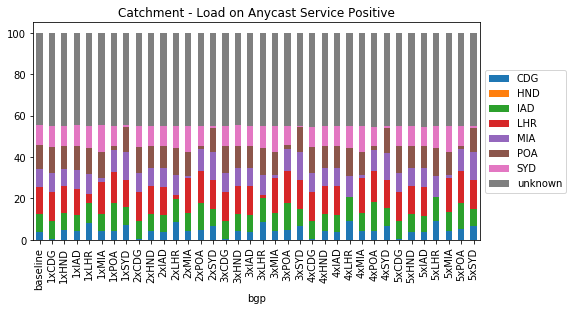

In [21]:
regex_prepend_site = "prepend|baseline|all"
data = df[df['bgp_policy'].str.contains(regex_prepend_site)].copy()
data = data[data['num_prepend']>=0]
data['num_prepend'] = data['num_prepend'].astype(str)
data['bgp'] = data['num_prepend']+"x"+ data['bgp_policy_location']
data.loc[data['bgp'].str.contains('0xbaseline'), 'bgp'] = 'baseline'
data = data.groupby(['site','bgp'])['percent'].sum().unstack().T.fillna(0)
data = pd.concat([data.tail(1),data])
data = data.drop_duplicates(keep="first")
fig = plt.figure(figsize=(8, 4))
ax = plt.subplot2grid((1,1), (0,0))
data.plot(ax=ax,
          kind='bar', 
          stacked=True,
         );
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5));
ax.set_title("Catchment - Load on Anycast Service Positive".format(site));  

## B - negative prepend

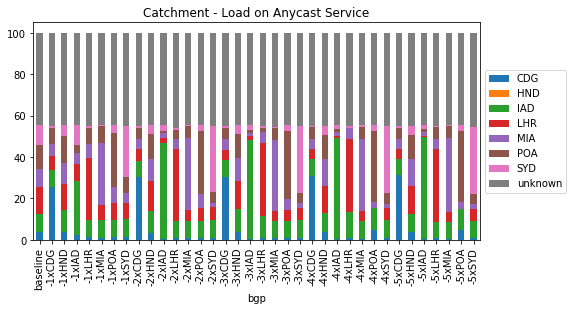

In [22]:
regex_prepend_site = "prepend|baseline|all"
data = df[df['bgp_policy'].str.contains(regex_prepend_site)].copy()
data = data[data['num_prepend']<=0]
data['num_prepend'] = data['num_prepend'].astype(str)
data['bgp'] = data['num_prepend']+"x"+ data['bgp_policy_location']
data.loc[data['bgp'].str.contains('0xbaseline'), 'bgp'] = 'baseline'
data = data.groupby(['site','bgp'])['percent'].sum().unstack().T.fillna(0)
data = pd.concat([data.tail(1),data])
data = data.drop_duplicates(keep="first")
fig = plt.figure(figsize=(8, 4))
ax = plt.subplot2grid((1,1), (0,0))
data.plot(ax=ax,
          kind='bar', 
          stacked=True,
         );
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5));
ax.set_title("Catchment - Load on Anycast Service".format(site));  

## C. Impact of path prepending in catchment 

245800.0


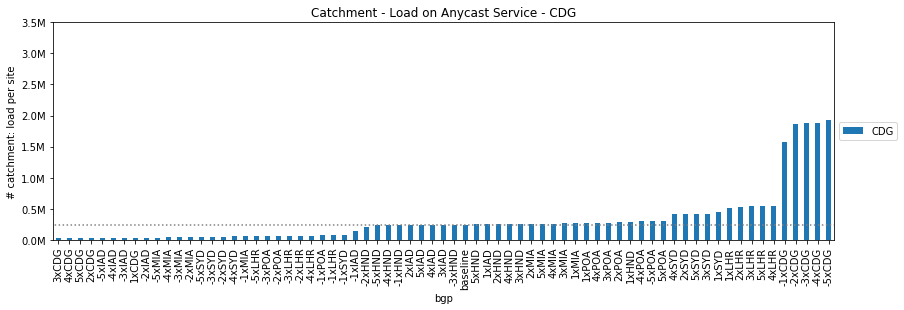

1.0


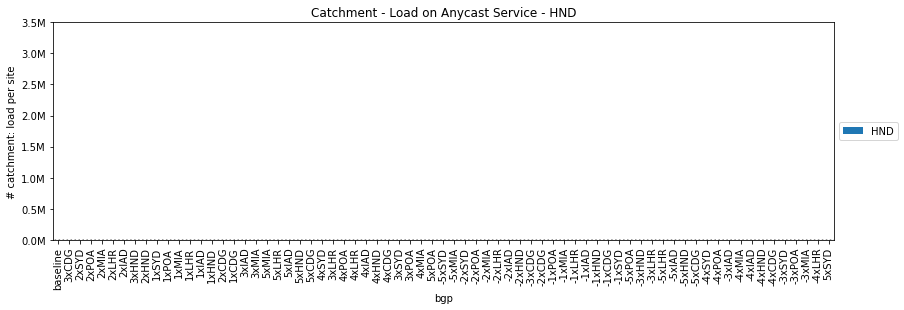

520290.0


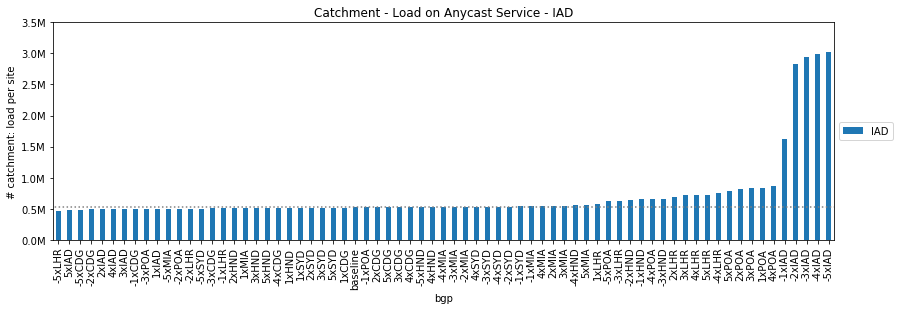

796172.0


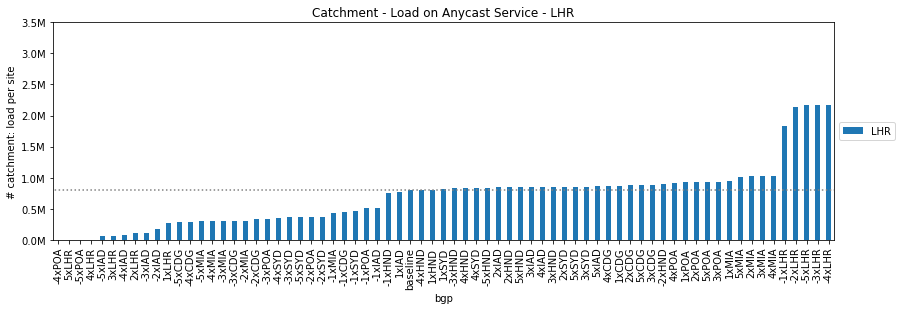

543614.0


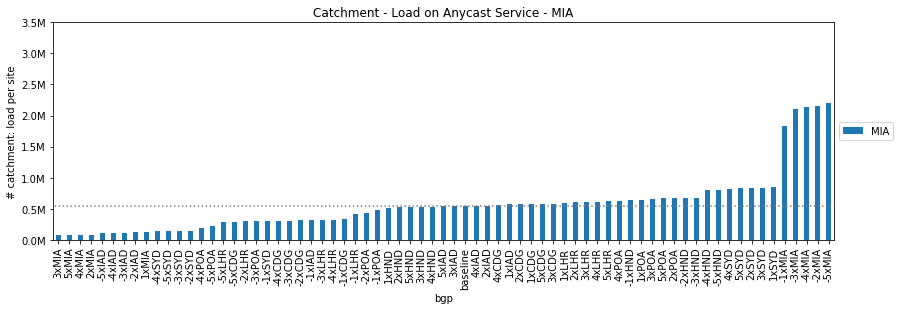

714439.0


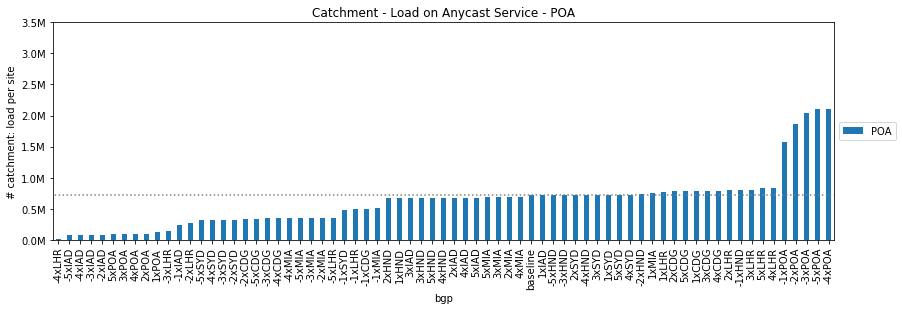

584351.0


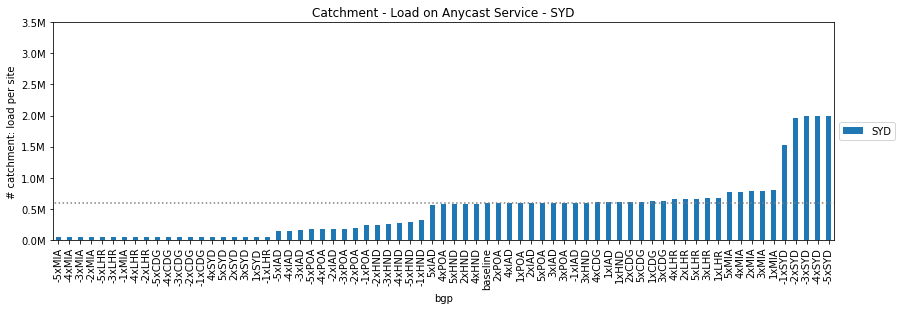

2750121.0


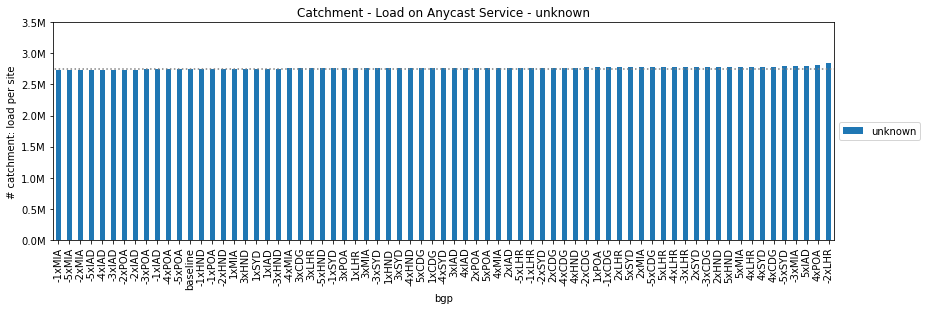

In [23]:
regex_prepend_site = "prepend|baseline|all"
data = df[df['bgp_policy'].str.contains(regex_prepend_site)].copy()
# data = data[data['num_prepend']>=0]
data['num_prepend'] = data['num_prepend'].astype(str)
data['bgp'] = data['num_prepend']+"x"+ data['bgp_policy_location']
data.loc[data['bgp'].str.contains('0xbaseline'), 'bgp'] = 'baseline'
data = data.groupby(['site','bgp'])['count'].sum().unstack().T.fillna(0)
data = pd.concat([data.tail(1),data])
data = data.drop_duplicates(keep="first")
columns_name = data.columns.get_level_values(0)

for col in columns_name:
    
    fig = plt.figure(figsize=(14, 4))
    ax = plt.subplot2grid((1,1), (0,0))
    
    data_site = data.loc[:,col].sort_values()
#     data_site = data.loc[:,col] 

    data_site.plot(ax=ax,
          kind='bar', 
          stacked=True,
         );
    df_site = data_site.reset_index()
    reference_value = data_site.reset_index()[df_site.bgp=="baseline"].iloc[0,1]
    print (reference_value)

   # label = "[{}%] BASELINE".format(int(reference_value))
   # ax.annotate(label,xy=(25, reference_value), ha='right',color='black',va='bottom')
    ax.axhline(y=reference_value, xmin=-1, xmax=1.0, color='grey', linestyle='dotted')
    
    ax.set_ylim(ymax=3500000, ymin=0);
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5));
#     ax.set_yticklabels(['{:.0f}%'.format(x*1) for x in plt.gca().get_yticks()]);
    ax.set_yticklabels(['{:,}M'.format((x/1000000)) for x in ax.get_yticks().tolist()])

    ax.set_title("Catchment - Load on Anycast Service - {}".format(col));  
    ax.set_ylabel('# catchment: load per site');
    title = "<h2 style=\"color:#069\" >How prepending affects the load of site: {} </h2>".format(col.upper())
    display(HTML(title))
    plt.show()
    

## same values, another visualization

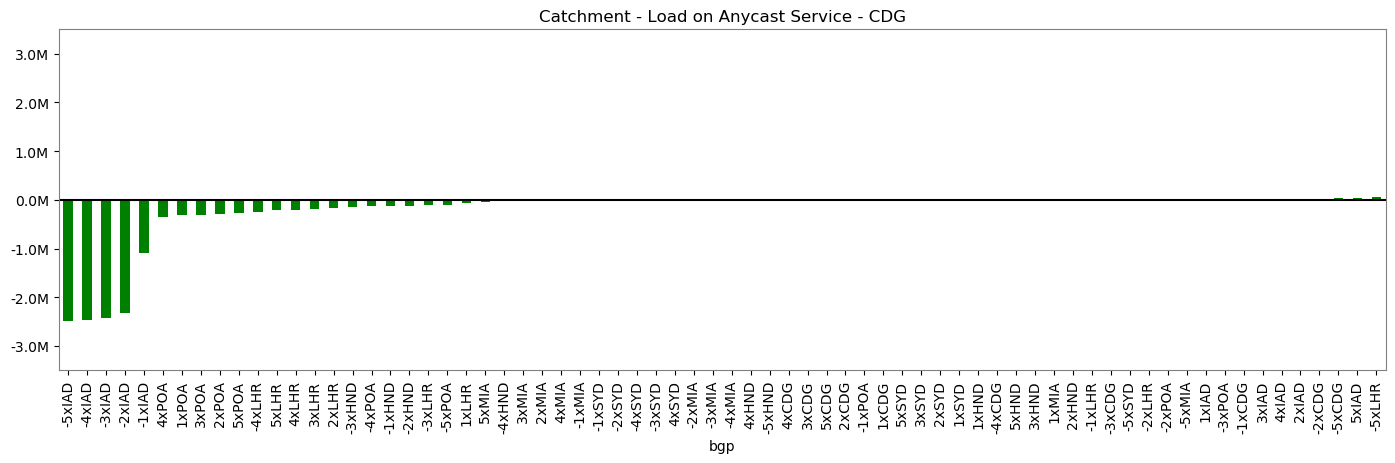

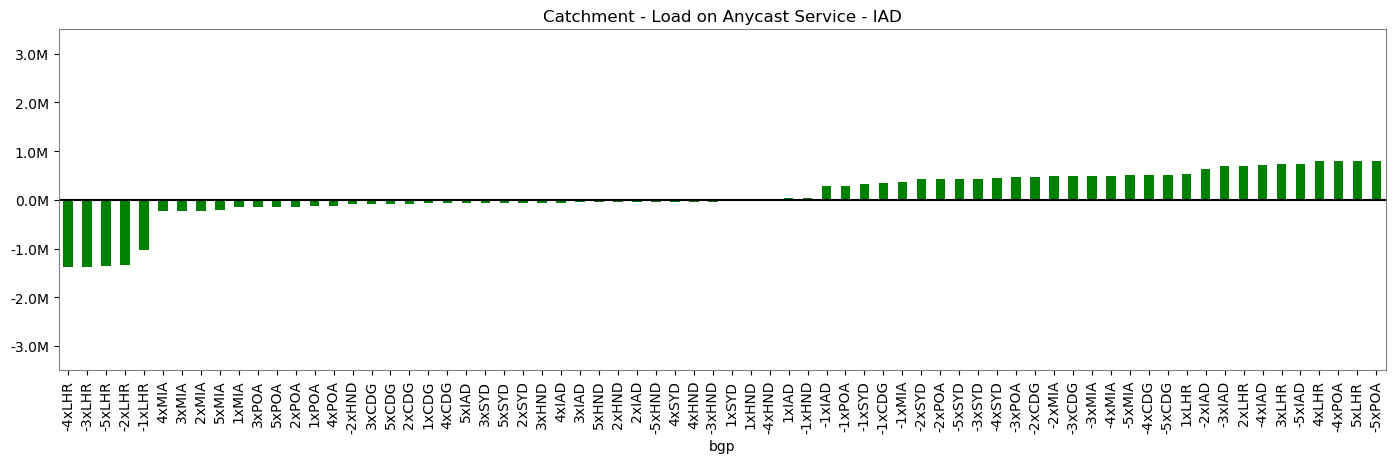

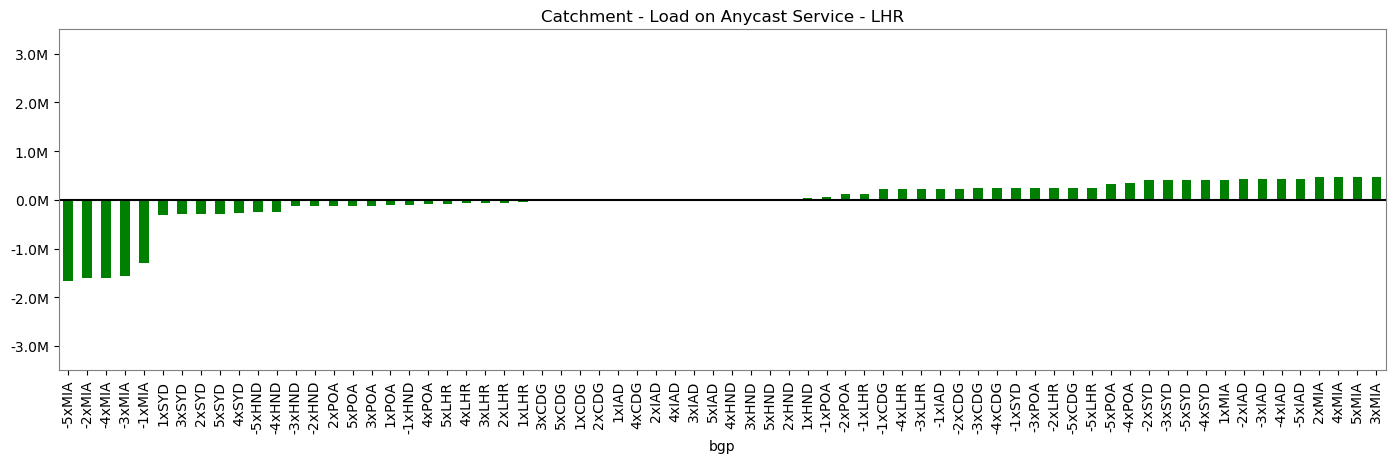

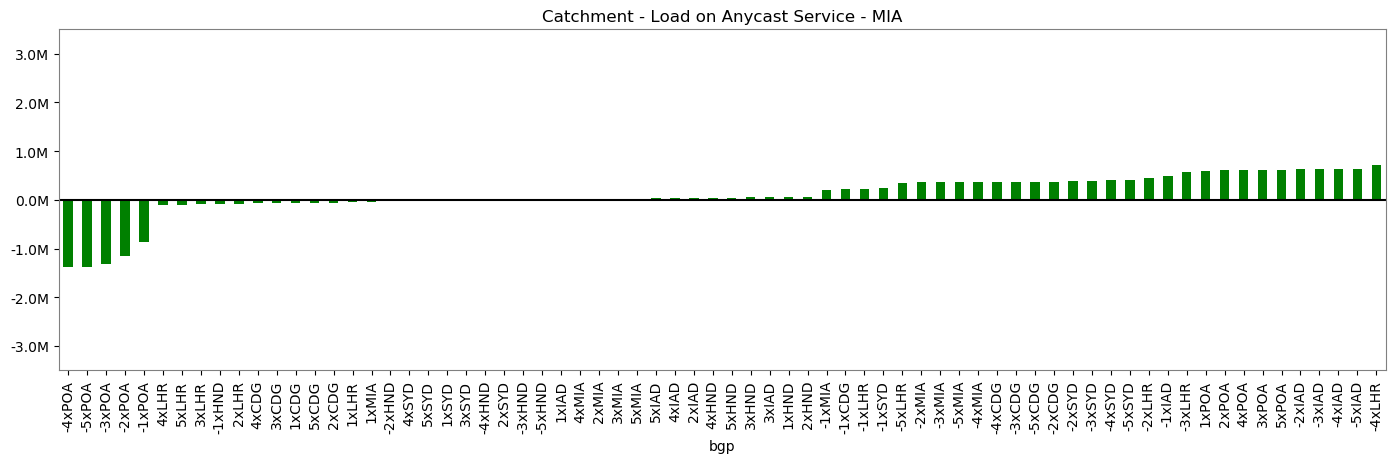

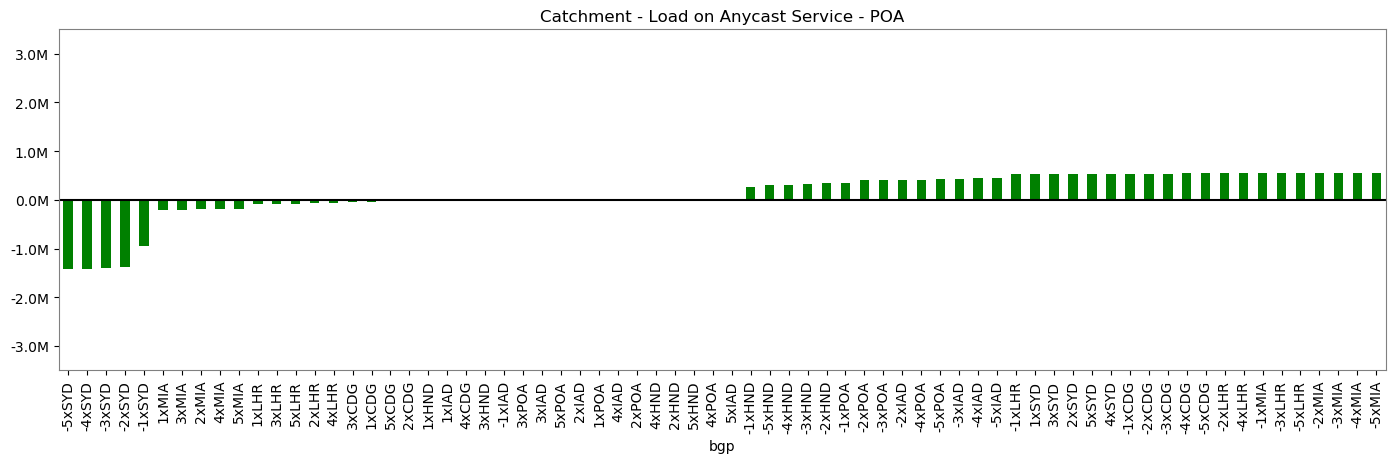

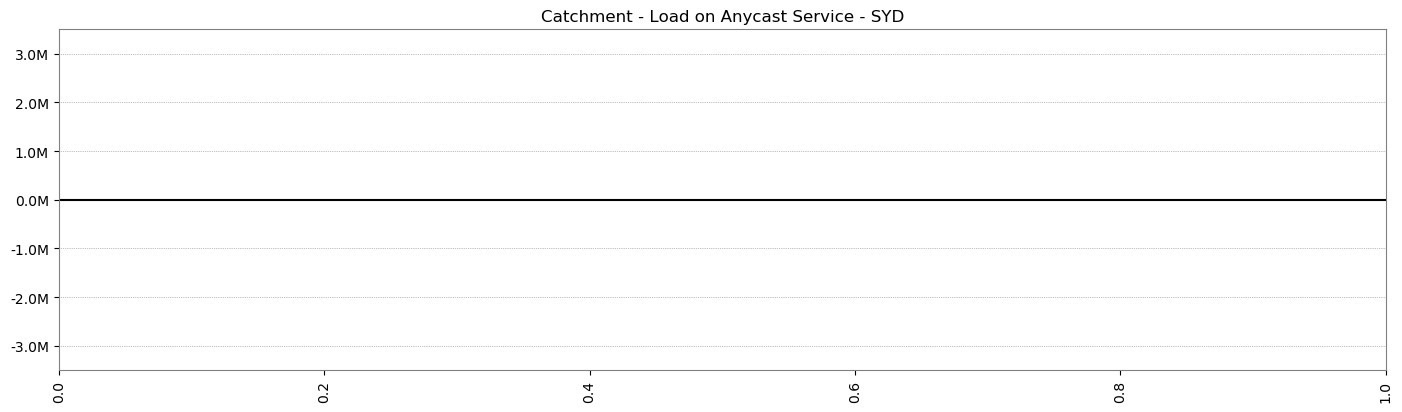

In [63]:
regex_prepend_site = "prepend|baseline|all"
data = df[df['bgp_policy'].str.contains(regex_prepend_site)].copy()
data['num_prepend'] = data['num_prepend'].astype(str)
data['bgp'] = data['num_prepend']+"x"+ data['bgp_policy_location']
data.loc[data['bgp'].str.contains('0xbaseline'), 'bgp'] = 'baseline'
data = data.groupby(['site','bgp'])['count'].sum().unstack().T.fillna(0)
data = pd.concat([data.tail(1),data])
data = data.drop_duplicates(keep="first")

data.drop('HND',1,inplace=True)
data.drop('unknown',1,inplace=True)    
columns_name = data.columns.get_level_values(0)

for site in columns_name:
    baseline  = data.iloc[[0]].values[0]
    data_diff = data.iloc[1:].apply(lambda x: (baseline-x), axis=1)  
    data_diff[site].sort_values().plot(kind="bar",ax=ax, stacked=False,color="green")

    (fig,ax) = init_fig(14,4)
    xlabels = ax.get_xticklabels()
    ax.set_xticklabels(xlabels,rotation=90);
    ax.set_ylim(ymax=3500000,ymin=-3500000);
    ax.axhline(y=0, xmin=-1, xmax=1.0, color="black")
    ax.yaxis.grid(color='grey', linestyle='dotted', linewidth=0.5)
    ax.set_title("Catchment - Load on Anycast Service - {}".format(site)); 
    ax.set_yticklabels(['{:,}M'.format((x/1000000)) for x in ax.get_yticks().tolist()]); 

## Leandro's Idea
## Anycast Service maximum and minimum

In [38]:
regex_prepend_site = "prepend|baseline|all"
data = df[df['bgp_policy'].str.contains(regex_prepend_site)].copy()
# data = data[data['num_prepend']>=0]
data['num_prepend'] = data['num_prepend'].astype(str)
data['bgp'] = data['num_prepend']+"x"+ data['bgp_policy_location']
data.loc[data['bgp'].str.contains('0xbaseline'), 'bgp'] = 'baseline'
data = data.groupby(['site','bgp'])['count'].sum().unstack().T.fillna(0)
data = pd.concat([data.tail(1),data])
data = data.drop_duplicates(keep="first")

# fix column names
data.columns=data.columns.get_level_values(0)
data.columns = data.columns.to_list()
df_prepend = data
df_prepend.head()

,CDG,HND,IAD,LHR,MIA,POA,SYD,unknown
bgp,,,,,,,,
baseline,245800.0,1.0,520290.0,796172.0,543614.0,714439.0,584351.0,2750121.0
-1xCDG,1566418.0,1.0,495453.0,443092.0,329853.0,497518.0,47549.0,2774904.0
-1xHND,235341.0,1.0,652208.0,759538.0,640007.0,801860.0,315584.0,2750249.0
-1xIAD,141394.0,1.0,1614949.0,507450.0,317966.0,231234.0,595158.0,2746636.0
-1xLHR,81971.0,1.0,508383.0,1829601.0,419133.0,492276.0,50899.0,2772524.0


In [39]:
data = pd.DataFrame()
regex_prepend_site = "prepend|baseline|with|all"
data = df[df['bgp_policy'].str.contains(regex_prepend_site)].copy()

data['num_prepend'] = data['num_prepend'].astype(str)
data['bgp'] = data['num_prepend']+"x"+ data['bgp_policy_location']
data.loc[data['bgp'].str.contains('0xbaseline'), 'bgp'] = 'baseline'
data = data.groupby(['site','bgp'])['count'].sum().unstack().T.fillna(0)
data.columns = data.columns.get_level_values(0).tolist()
data = pd.concat([data.tail(1),data])
data = data.drop_duplicates(keep="first")
data.to_csv("prepend+withdraw-dataframe.csv",sep=";")

In [40]:
pwd

'/Users/ceron/work/SAND/paper_bgp_catchment_manipulation/data_analysis/server_load'

In [41]:
df[df['bgp_policy'].str.contains("withdraw-au-syd-anycast01")]

,site,count,percent,time,bgp_policy_location,num_prepend,community,bgp_policy
0,MIA,829334,13.475,2020-02-05-12:54:36,SYD,0,None,withdraw-au-syd-anycast01
1,LHR,823306,13.377,2020-02-05-12:54:36,SYD,0,None,withdraw-au-syd-anycast01
2,POA,724302,11.768,2020-02-05-12:54:36,SYD,0,None,withdraw-au-syd-anycast01
3,IAD,519713,8.444,2020-02-05-12:54:36,SYD,0,None,withdraw-au-syd-anycast01
4,CDG,470715,7.648,2020-02-05-12:54:36,SYD,0,None,withdraw-au-syd-anycast01
5,HND,1,0.000,2020-02-05-12:54:36,SYD,0,None,withdraw-au-syd-anycast01
6,unknown,2787417,45.289,2020-02-05-12:54:36,SYD,0,None,withdraw-au-syd-anycast01


### Extract MAX/MIN/BASELINE from prepend dataframe for each node

In [42]:
# get max value per line
max_policy_label = data.T.idxmax(axis=1)
max_policy_value=data.T.max(axis=1)

# get min value per line
min_policy_label = data.T.idxmin(axis=1)
min_policy_value=data.T.min(axis=1)

# get baseline values
df_baseline = data.iloc[0,:]

# build dataframe
df_result = pd.concat([max_policy_value,
                       min_policy_value,
                       df_baseline,max_policy_label,
                       min_policy_label],
                       axis=1
                     ) 
df_result.columns=['max','min','baseline','max_label','min_label']
# remove nodes
df_result = df_result[df_result.index!="unknown"]
df_result = df_result[df_result.index!="HND"]

,max,min,baseline,max_label,min_label
CDG,1928542.0,0.0,245800.0,-5xCDG,0xCDG
IAD,3015529.0,0.0,520290.0,-5xIAD,0xIAD
LHR,2175304.0,0.0,796172.0,-4xLHR,-4xPOA
MIA,2203564.0,0.0,543614.0,-5xMIA,0xMIA
POA,2104090.0,0.0,714439.0,-4xPOA,0xPOA
SYD,1997357.0,0.0,584351.0,-5xSYD,0xSYD


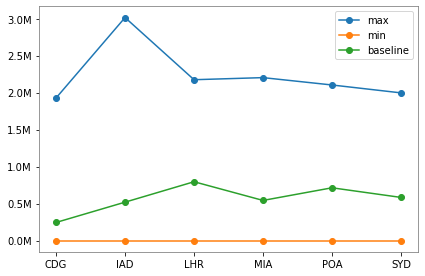

In [43]:
fig = plt.figure(figsize=(6, 4))
ax = plt.subplot(111)   
ax = plt.subplot2grid((1,1), (0,0))

ax.spines['bottom'].set_color('0.5')
ax.spines['top'].set_color('0.5')
ax.spines['right'].set_color('0.5')
ax.spines['left'].set_color('0.5')
fig.tight_layout();
plt.style.use('default')

df_result[['max','min','baseline']].plot(marker='o',ax=ax)
ax.set_yticklabels(['{:,}M'.format((x/1000000)) for x in ax.get_yticks().tolist()])

df_result

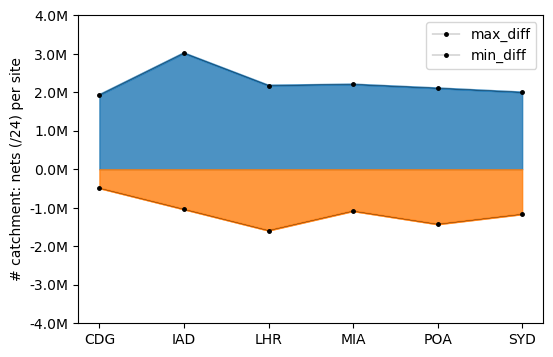

In [44]:
df_result['max_diff'] = (df_result['max'] - df_result['baseline'])   + df_result['baseline']
df_result['min_diff'] = (df_result['min'] - df_result['baseline'] ) - df_result['baseline']
fig = plt.figure(figsize=(6, 4))
ax = plt.subplot2grid((1,1), (0,0))
df_result[['max_diff','min_diff']].plot(kind='area',ax=ax,alpha=0.8)
df_result[['min_diff']].plot(kind='line',marker=".",
                             markersize=5,
                             color="black",
                              linewidth=0.2,
                             ax=ax,legend=[])
df_result[['max_diff']].plot(kind='line',marker=".",
                             markersize=5,
                             color="black",
                              linewidth=0.2,
                             ax=ax,legend=[])
ax.set_ylim(ymax=4000000, ymin=-4000000);
ax.set_yticklabels(['{:,}M'.format((x/1000000)) for x in ax.get_yticks().tolist()]);
ax.set_ylabel('# catchment: nets (/24) per site');
# ax2 = ax.twinx()
# ax.get_yticks().tolist()


In [45]:
# data_site.iloc[0:1][0]
# data_site[data_site.iloc[0]=="baseline"]

df_site = data_site.reset_index()
reference_value = data_site.reset_index()[df_site.bgp=="baseline"].iloc[0,1]
reference_value

2750121.0

---
---
<h1 align="center">Effect of prepeding on each site</h1>

---
---

In [46]:
available_nodes = df_prepend.columns.to_list()
available_nodes.remove('unknown')
available_nodes.remove('HND')
available_nodes

['CDG', 'IAD', 'LHR', 'MIA', 'POA', 'SYD']

CDG


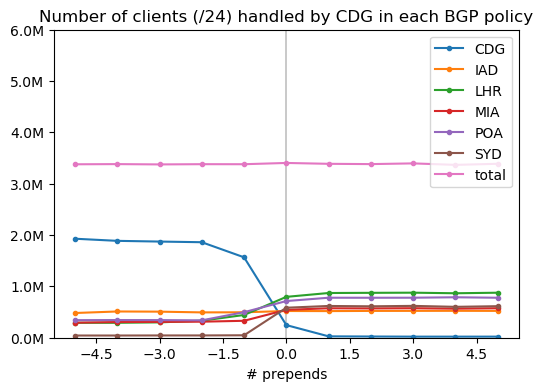

IAD


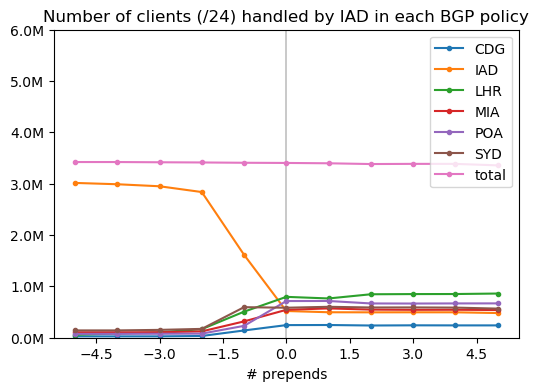

LHR


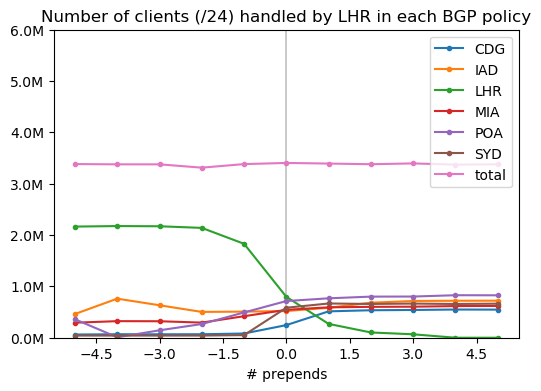

MIA


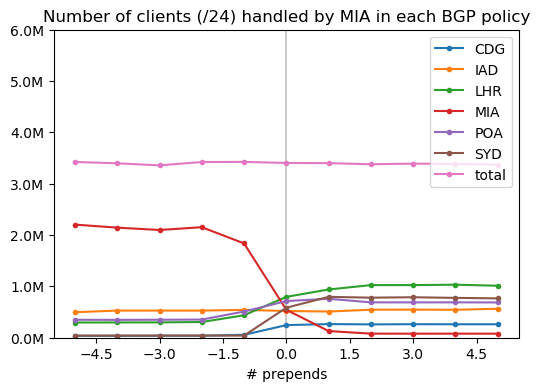

POA


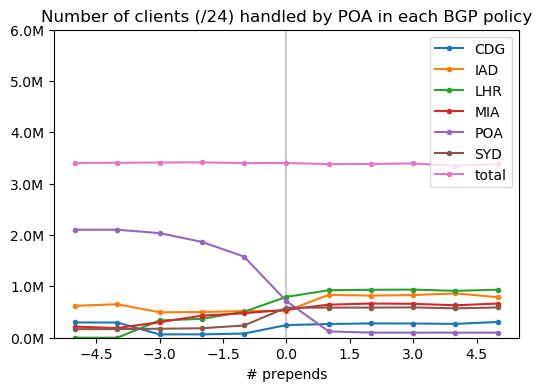

SYD


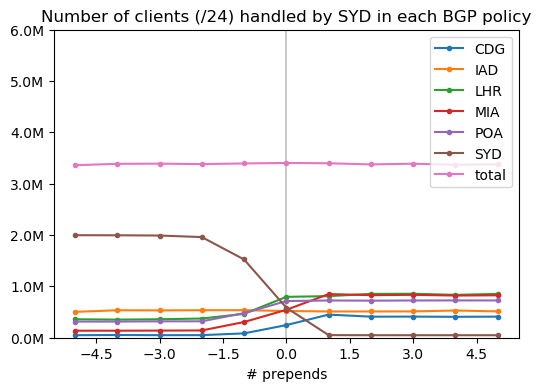

In [47]:
for prepend_site in available_nodes:

    data = df_prepend.copy()
    print (prepend_site)
    # prepare dataframe
    regex_prepend_site = prepend_site+"|baseline|all"
    data = data[data.index.str.contains(regex_prepend_site)]
    data.drop('HND',1,inplace=True)
    data.drop('unknown',1,inplace=True)
    data.reset_index(inplace=True)
    data[['num_prepend','loc_prepend']] = data.bgp.str.split("x",expand=True)
    data.loc[data['num_prepend'] == "baseline", ['num_prepend']] =  0
    data.num_prepend = data.num_prepend.astype(int)
    data = data.sort_values(by='num_prepend', ascending=True)
    data = data.set_index('num_prepend')
    data.drop('loc_prepend',1,inplace=True)
    data.drop('bgp',1,inplace=True)
    data['total'] = data.sum(axis=1)
    
    # prepare graph
    fig = plt.figure(figsize=(6, 4))
    ax = plt.subplot(111)   
    ax.set_ylim(ymax=6000000);
    ax.axvline(x=0, color='black',linewidth=0.3)
    ax.xaxis.set_major_locator(plt.MaxNLocator(10))
    data.plot(kind="line",ax=ax, marker=".")
    ax.set_xlabel('# prepends');
    ax.set_title("Number of clients (/24) handled by {} in each BGP policy".format(prepend_site));   
    ax.set_yticklabels(['{:,}M'.format((x/1000000)) for x in ax.get_yticks().tolist()])
    plt.show()

---
---
<h1 align="center">Effect of self-prepending on all the sites</h1>

---
---

In [48]:
available_nodes = df_prepend.columns.to_list()
available_nodes.remove('unknown')
available_nodes.remove('HND')
available_nodes

['CDG', 'IAD', 'LHR', 'MIA', 'POA', 'SYD']

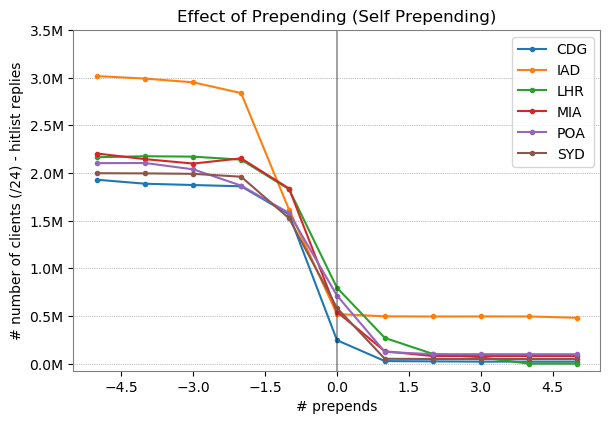

In [49]:
(fig,ax) = init_fig(6,4)
ax.set_title("Effect of Prepending (Self Prepending)")

for prepend_site in available_nodes:
# for prepend_site in  ['CDG']: 

    # prepare dataset
    data = df_prepend.copy()
    regex_prepend_site = prepend_site+"|baseline|all"
    data = data[data.index.str.contains(regex_prepend_site)][prepend_site]
    self_prepending = data
    data = data.reset_index()

    data[['num_prepend','loc_prepend']] = data.bgp.str.split("x",expand=True)
    data.loc[data['num_prepend'] == "baseline", ['num_prepend']] =  0
    data.num_prepend = data.num_prepend.astype(int)
    data = data.sort_values(by='num_prepend', ascending=True)
    data = data.set_index('num_prepend')
    data.drop('loc_prepend',1,inplace=True)
    data.drop('bgp',1,inplace=True)
    
    
    # plot graph
    data.plot(kind="line",
              marker=".",
              ax= ax)
    
    ax.set_ylim(ymax=3500000);
    ax.axvline(x=0, color='black',linewidth=0.1)
    ax.xaxis.set_major_locator(plt.MaxNLocator(10))
    ax.set_yticklabels(['{:,}M'.format((x/1000000)) for x in ax.get_yticks().tolist()])
    ax.set_ylabel('# number of clients (/24) - hitlist replies');

    ax.set_xlabel('# prepends');

#     filename = "/Users/joaoceron/work/WORKING/ANT_GIT/PAPERS/ddos_anycast/FIG/TANGLED/self_prepending_tangled.pdf"
    ax.set_yticklabels(['{:,}M'.format((x/1000000)) for x in ax.get_yticks().tolist()])
#     fig.savefig(filename, bbox_inches='tight', dpi=1200)

    ax.yaxis.grid(color='grey', linestyle='dotted', linewidth=0.5)

In [50]:
data = df_prepend.copy()
data.head()
data.drop('unknown',1,inplace=True)
data['total'] = data.sum(axis=1)
data
data_percent = pd.DataFrame()
data_percent['bgp'] = data.index
data = data.reset_index()
data_percent
data.head()

for node in data.columns[1:8]:
    node_pct = "{}_pct".format(node)
    data_percent[node] = (data[node]/data['total']).mul(100).round(3)
data_percent.head(1)
data_percent.set_index('bgp',inplace=True)

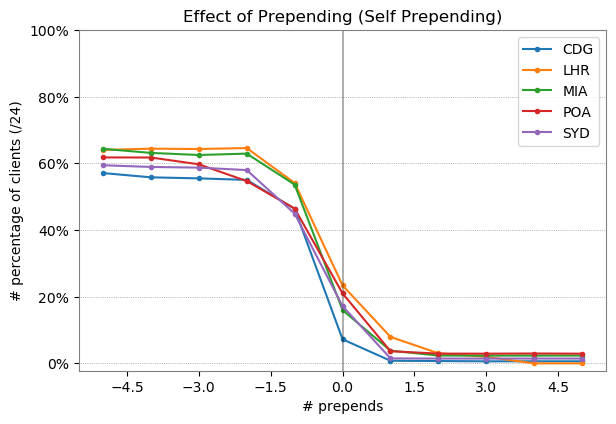

In [51]:
(fig,ax) = init_fig(6,4)
ax.set_title("Effect of Prepending (Self Prepending)")
available_nodes = ['CDG', 'LHR', 'MIA', 'POA', 'SYD']
# available_nodes = ['CDG', 'LHR']
for prepend_site in available_nodes:
# for prepend_site in  ['CDG']: 

    # prepare dataset
    data = data_percent.copy()
    regex_prepend_site = prepend_site+"|baseline|all"
    data = data[data.index.str.contains(regex_prepend_site)][prepend_site]
    self_prepending = data
    data = data.reset_index()

    data[['num_prepend','loc_prepend']] = data.bgp.str.split("x",expand=True)
    data.loc[data['num_prepend'] == "baseline", ['num_prepend']] =  0
    data.num_prepend = data.num_prepend.astype(int)
    data = data.sort_values(by='num_prepend', ascending=True)
    data = data.set_index('num_prepend')
    data.drop('loc_prepend',1,inplace=True)
    data.drop('bgp',1,inplace=True)
    
    
    # plot graph
    data.plot(kind="line",
              marker=".",
              ax= ax)
    
    ax.axvline(x=0, color='black',linewidth=0.1)
    ax.xaxis.set_major_locator(plt.MaxNLocator(10))
    ax.set_ylabel('# percentage of clients (/24)');

    ax.set_xlabel('# prepends');
    ax.set_ylim(ymax=100);
    plt.gca().set_yticklabels(['{:.0f}%'.format(x*1) for x in plt.gca().get_yticks()]);

#     filename = "/Users/joaoceron/work/WORKING/ANT_GIT/PAPERS/ddos_anycast/FIG/TANGLED/self_prepending_tangled.pdf"
#     ax.set_yticklabels(['{:,}M'.format((x/1000000)) for x in ax.get_yticks().tolist()])
#     fig.savefig(filename, bbox_inches='tight', dpi=1200)

    ax.yaxis.grid(color='grey', linestyle='dotted', linewidth=0.5)

---
---
<h1 align="center">Regular Prepending vs Community prepend</h1>

---
---

# VULTR

In [1714]:
df_all.num_prepend = df_all.num_prepend.astype(int)
df_ampath = df_all[df_all['bgp_policy_location'].str.contains("ampath")].copy()
df_ampath_community = df_ampath[df_ampath.bgp_policy.str.contains("community")]
df_ampath_prepend = df_ampath[~df_ampath.bgp_policy.str.contains("community")]

In [1717]:
# df_ampath_prepend

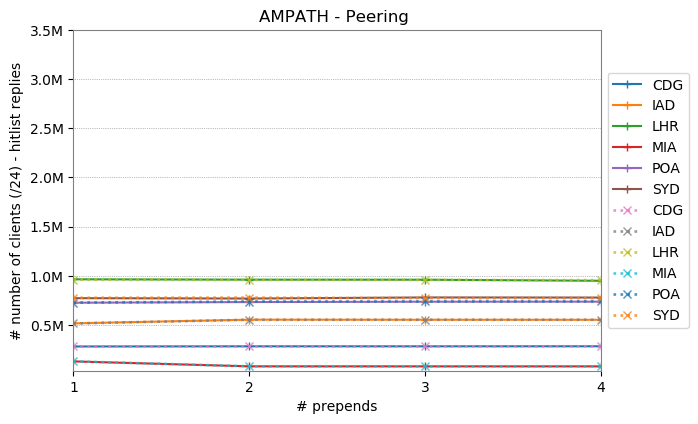

In [1785]:

df_all.num_prepend = df_all.num_prepend.astype(int)
df_ampath = df_all[df_all['bgp_policy_location'].str.contains("ampath")].copy()
df_ampath_community = df_ampath[df_ampath.bgp_policy.str.contains("community")]
df_ampath_prepend = df_ampath[~df_ampath.bgp_policy.str.contains("community")]

available_nodes = df_prepend.columns.to_list()
available_nodes.remove('unknown')
available_nodes.remove('HND')
available_nodes

(fig,ax) = init_fig(6,4)

for prepend_site in available_nodes:
    
    data = df_ampath_community[df_ampath_community.site.str.contains(prepend_site)]
    a = pd.pivot_table(data,index=["site"],values=['count'],columns=["num_prepend"]).fillna(0).droplevel(0, axis=1)
    data = a.T
    data.plot(kind="line",
                  marker="+",
                  ax= ax)
    
    ax.xaxis.set_major_locator(plt.MaxNLocator(3))
    ax.set_yticklabels(['{:,}M'.format((x/1000000)) for x in ax.get_yticks().tolist()])
    

for prepend_site in available_nodes:
    
    data = df_ampath_prepend[df_ampath_prepend.site.str.contains(prepend_site)]
    a = pd.pivot_table(data,index=["site"],values=['count'],columns=["num_prepend"]).fillna(0).droplevel(0, axis=1)
    data = a.T
    data.plot(kind="line",
                  marker="x",
                  ax= ax,
                  alpha = 1.8,
                  linestyle='dotted',
                  linewidth=1.9
             )
    ax.set_title("AMPATH - Peering "); 
    
    ax.set_ylim(ymax=3500000);
    ax.set_xlabel('# prepends');
    ax.set_ylabel('# number of clients (/24) - hitlist replies');
    ax.xaxis.set_major_locator(plt.MaxNLocator(3))
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5));
    ax.set_yticklabels(['{:,}M'.format((x/1000000)) for x in ax.get_yticks().tolist()])
    
    ax.yaxis.grid(color='grey', linestyle='dotted', linewidth=0.5)
    filename = "/Users/joaoceron/work/WORKING/ANT_GIT/PAPERS/ddos_anycast/FIG/TANGLED/ampath-prepending.pdf"
    fig.savefig(filename, bbox_inches='tight', dpi=1200)

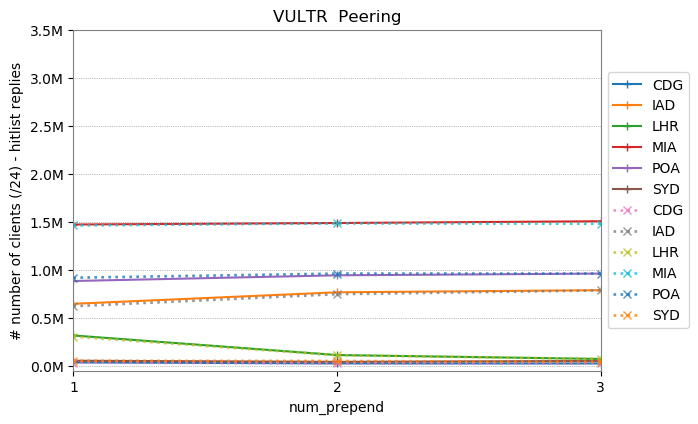

In [1784]:

df_all.num_prepend = df_all.num_prepend.astype(int)
df_ampath = df_all[df_all['bgp_policy_location'].str.contains("vultr")].copy()
df_ampath_community = df_ampath[df_ampath.bgp_policy.str.contains("community")]
df_ampath_prepend = df_ampath[~df_ampath.bgp_policy.str.contains("community")]

available_nodes = df_prepend.columns.to_list()
available_nodes.remove('unknown')
available_nodes.remove('HND')
available_nodes

(fig,ax) = init_fig(6,4)

for prepend_site in available_nodes:
    
    data = df_ampath_community[df_ampath_community.site.str.contains(prepend_site)]
    a = pd.pivot_table(data,index=["site"],values=['count'],columns=["num_prepend"]).fillna(0).droplevel(0, axis=1)
    data = a.T
    data.plot(kind="line",
                  marker="+",
                  ax= ax)
    
    ax.xaxis.set_major_locator(plt.MaxNLocator(3))
    ax.set_yticklabels(['{:,}M'.format((x/1000000)) for x in ax.get_yticks().tolist()])
    

for prepend_site in available_nodes:
    
    data = df_ampath_prepend[df_ampath_prepend.site.str.contains(prepend_site)]
    a = pd.pivot_table(data,index=["site"],values=['count'],columns=["num_prepend"]).fillna(0).droplevel(0, axis=1)
    data = a.T
    data.plot(kind="line",
                  marker="x",
                  ax= ax,
                  alpha = 1.8,
                  linestyle='dotted',
                  linewidth=1.9
             )
    ax.set_ylim(ymax=3500000);

    ax.set_title("VULTR  Peering");   
    ax.xaxis.set_major_locator(plt.MaxNLocator(2))
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5));
    ax.xaxis.set_major_locator(plt.MaxNLocator(2))
    ax.set_ylabel('# number of clients (/24) - hitlist replies');

    ax.yaxis.grid(color='grey', linestyle='dotted', linewidth=0.5)
    filename = "/Users/joaoceron/work/WORKING/ANT_GIT/PAPERS/ddos_anycast/FIG/TANGLED/vultr-prepending.pdf"
    ax.set_yticklabels(['{:,}M'.format((x/1000000)) for x in ax.get_yticks().tolist()])
    fig.savefig(filename, bbox_inches='tight', dpi=1200)